хочу быстро проверить 3 вещи:<br>
- есть ли пересечение по id для train / test
- какое у нас пересечение по времени для train / test
- для трейна: есть ли такое, что после того как прошла фродовая транзакция - все остальные тоже фродовые

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import datetime
import sklearn
import sqlalchemy as sa
import multiprocessing

In [2]:
from sklearn.model_selection import TimeSeriesSplit

import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import precision_recall_curve, auc

import operator

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', -1)

In [4]:
import os
import re
import networkx as nx
from tqdm import tqdm, tqdm_notebook
import gc

In [5]:
feature_descr = {'cdf_s_178_hashed':'реквизит получателя',
                'cdf_s_123': 'региональный признак получателя',
                'cdf_s_124':'дата выдачи карты получателя',
                'cdf_s_294': 'возраст получателя',
                'cdf_s_19': 'ДР клиента',
                 'cdf_s_20':' Тер банк клиента',
                 'cdf_s_299':'Тер банк получателя',
                 'data_i_154':'Признаки устр-ва',
                 'data_i_118':'Признаки устр-ва', 'data_i_119':'Признаки устр-ва',
                 'data_i_120':'Признаки устр-ва', 
                 'cdf_s_136':'cusum_web',
                 'cdf_s_137':'cusum_МП',
                 'cdf_s_140':'cusum_web + МП',
                 'data_s_65':'связь отправитель-получатель',
                 'cdf_s_218':'предположение о родственной связи',
                 'user_acct_number_hashed':' счет отправителя (хэшированный)',
                 'ext_acct_number_hashed':'счет получателя (хэшированный)',
                 'amount_original':'сумма в рублях',
                 'event_description':'описание события',
                 'channel_indicator_desc':'канал проведения операции',
                 'custom_mark':'результат разбора события',
                 'event_id':'уникальный id транзакции',
                 'short_date':'дата (для удобства поиска/агрегации)',
                 'user_id':'уникальный идентификатор клиента',
                 'event_time':'дата и время события'
                }
risk_events = {key:'дней с рискового события' for key in ['cdf_s_127', 'cdf_s_135', 'cdf_s_130', 'cdf_s_129', 'cdf_s_134', 'cdf_s_128', 'cdf_s_138', 'cdf_s_126']}
feature_descr.update(risk_events)

In [6]:
FIRST_N = 100
train_folder = '../../data/raw_splits/train/'
train_files = sorted([x for x in os.listdir(train_folder) if not '.pkl' in x], key = lambda x: int(re.sub('[^0-9]', '', x)))
train_files = [os.path.join(train_folder, x) for x in train_files]
print(f'Length of train files is {len(train_files)}')
train_files[:FIRST_N]

Length of train files is 51


['../../data/raw_splits/train/chunk_0.fth',
 '../../data/raw_splits/train/chunk_1.fth',
 '../../data/raw_splits/train/chunk_2.fth',
 '../../data/raw_splits/train/chunk_3.fth',
 '../../data/raw_splits/train/chunk_4.fth',
 '../../data/raw_splits/train/chunk_5.fth',
 '../../data/raw_splits/train/chunk_6.fth',
 '../../data/raw_splits/train/chunk_7.fth',
 '../../data/raw_splits/train/chunk_8.fth',
 '../../data/raw_splits/train/chunk_9.fth',
 '../../data/raw_splits/train/chunk_10.fth',
 '../../data/raw_splits/train/chunk_11.fth',
 '../../data/raw_splits/train/chunk_12.fth',
 '../../data/raw_splits/train/chunk_13.fth',
 '../../data/raw_splits/train/chunk_14.fth',
 '../../data/raw_splits/train/chunk_15.fth',
 '../../data/raw_splits/train/chunk_16.fth',
 '../../data/raw_splits/train/chunk_17.fth',
 '../../data/raw_splits/train/chunk_18.fth',
 '../../data/raw_splits/train/chunk_19.fth',
 '../../data/raw_splits/train/chunk_20.fth',
 '../../data/raw_splits/train/chunk_21.fth',
 '../../data/raw_spl

In [7]:
test_folder = '../../data/raw_splits/test/'
test_files = sorted([x for x in os.listdir(test_folder) if not '.pkl' in x], key = lambda x: int(re.sub('[^0-9]', '', x)))
test_files = [os.path.join(test_folder, x) for x in test_files]
print(f'Length of test files is {len(test_files)}')
test_files[:FIRST_N]

Length of test files is 26


['../../data/raw_splits/test/chunk_0.fth',
 '../../data/raw_splits/test/chunk_1.fth',
 '../../data/raw_splits/test/chunk_2.fth',
 '../../data/raw_splits/test/chunk_3.fth',
 '../../data/raw_splits/test/chunk_4.fth',
 '../../data/raw_splits/test/chunk_5.fth',
 '../../data/raw_splits/test/chunk_6.fth',
 '../../data/raw_splits/test/chunk_7.fth',
 '../../data/raw_splits/test/chunk_8.fth',
 '../../data/raw_splits/test/chunk_9.fth',
 '../../data/raw_splits/test/chunk_10.fth',
 '../../data/raw_splits/test/chunk_11.fth',
 '../../data/raw_splits/test/chunk_12.fth',
 '../../data/raw_splits/test/chunk_13.fth',
 '../../data/raw_splits/test/chunk_14.fth',
 '../../data/raw_splits/test/chunk_15.fth',
 '../../data/raw_splits/test/chunk_16.fth',
 '../../data/raw_splits/test/chunk_17.fth',
 '../../data/raw_splits/test/chunk_18.fth',
 '../../data/raw_splits/test/chunk_19.fth',
 '../../data/raw_splits/test/chunk_20.fth',
 '../../data/raw_splits/test/chunk_21.fth',
 '../../data/raw_splits/test/chunk_22.fth'

In [8]:
# функция получения lable из csutom_mark

def cust_mark_to_class(custom_mark):
    """
    Преобразует входящее значение CUSTOM_MARK в класс
    return:
        1 - фрод
        0 - легитимная
        -1 - неизвестно
    """
    ret = -1
    if custom_mark in ['F','S']:
        ret = 1
    elif custom_mark in ['A','G', 'null']:
        ret = 0
    
    return ret

---

In [9]:
def load_train(fname):
    chunk = pd.read_feather(fname)
    return chunk[['user_id', 'short_date', 'custom_mark']].copy()

def load_test(fname):
    chunk = pd.read_feather(fname)
    return chunk[['user_id', 'short_date']].copy()

In [ ]:
%%time
with multiprocessing.Pool(processes=5) as pool:
    train_chunks = pool.map(load_train, train_files)

In [ ]:
%%time
with multiprocessing.Pool(processes=5) as pool:
    test_chunks = pool.map(load_test, test_files)

In [10]:
chunk = pd.read_feather(train_files[0])

In [53]:
chunk.head()

,cdf_s_123,cdf_s_124,cdf_s_127,cdf_s_135,cdf_s_130,cdf_s_129,cdf_s_134,cdf_s_128,cdf_s_138,cdf_s_126,cdf_s_133,cdf_s_136,cdf_s_137,cdf_s_140,cdf_s_178_hashed,cdf_s_19,cdf_s_20,cdf_s_218,cdf_s_294,cdf_s_299,amount_original,channel_indicator_desc,custom_mark,data_i_118,data_i_119,data_i_120,data_i_154,data_s_65,event_description,event_id,event_time,ext_acct_number_hashed,hardwareid,short_date,user_acct_number_hashed,user_agent_string_hash,browser_plugins_hash,screen_hash,user_id,ip_address,ip_country,ip_region,ip_city,ip_isp
0,NaT,NaT,null,null,null,null,null,null,НЕТ,ДА,1,null,1000000,1000000,null,1977-02-15,99,НЕТ,39,99,10000.0,MOBILEAPI,null,1,1,1,86,339,Перевод частному лицу,48d1:85b16da1e51:18ac3165-_TRX,2017-08-25 22:47:42,427a42d0ad91a628ac4645f1e30ceb70172203d8,354021080277617,20170825,4bc31cd95fbac78ee5e4ca131c4cdca9e2b7688e,null,null,null,100197,31.173.86.8,ru,48,Moscow,7255560
1,NaT,NaT,null,null,null,null,4,null,null,null,null,null,null,null,null,1977-02-15,99,null,null,null,null,MOBILEAPI,null,null,null,null,0,null,Вход в систему с одноразовым паролем,cc83-:56fb8030061:3b046184_TRX,2017-11-28 17:33:56,null,null,20171128,null,null,null,null,100197,31.173.82.117,ru,48,Moscow,7255560
2,NaT,NaT,null,null,null,null,6,null,НЕТ,ДА,null,null,null,null,null,1977-02-15,99,null,null,null,1600.0,MOBILEAPI,null,1,1,1,8,641,Перевод между своими счетами и картами,05b5-:6e7f4a1eb51:8d9d0951-_TRX,2017-05-07 09:46:44,4bc31cd95fbac78ee5e4ca131c4cdca9e2b7688e,354021080277617,20170507,ba8d3b00c24ad4923f70e1a66f726586823b7899,null,null,null,100197,31.173.85.200,ru,48,Moscow,7255560
3,NaT,NaT,null,null,null,null,null,null,null,null,null,null,null,null,null,1977-02-15,99,null,null,null,null,MOBILEAPI,null,1,1,1,58,null,Вход в систему с одноразовым паролем,5453-:7167d798d51:c4ea7027-_TRX,2017-07-28 17:03:27,null,354021080277617,20170728,null,null,null,null,100197,31.173.82.110,ru,48,Moscow,7255560
4,NaT,NaT,null,null,null,null,6,null,НЕТ,ДА,4,null,1820000,1820000,null,1977-02-15,99,НЕТ,null,null,18200.0,MOBILEAPI,null,1,1,1,105,41,Перевод частному лицу,a93-:a666afa7e51:e52e957_TRX,2017-09-13 14:30:56,c433b3d9216eb8da92dde9b23549cbc6606b7638,354021080277617,20170913,4bc31cd95fbac78ee5e4ca131c4cdca9e2b7688e,null,null,null,100197,31.173.81.68,ru,48,Moscow,7255560


In [11]:
cdf_cols = [c for c in chunk.columns.values if c.startswith('cdf')]
#cdf_cols.remove('cdf_s_19', 'cdf_s_123', 'cdf_s_124')
len(cdf_cols)

20

In [32]:
chunk['cdf_s_140'].unique()

array(['1000000', 'null', '1820000', ..., '5089400', '4989400', '1789400'],
      dtype=object)

In [28]:
for c in chunk.columns.values:
    print(c, chunk[c].dtype)

cdf_s_123 datetime64[ns]
cdf_s_124 datetime64[ns]
cdf_s_127 object
cdf_s_135 object
cdf_s_130 object
cdf_s_129 object
cdf_s_134 object
cdf_s_128 object
cdf_s_138 object
cdf_s_126 object
cdf_s_133 object
cdf_s_136 object
cdf_s_137 object
cdf_s_140 object
cdf_s_178_hashed object
cdf_s_19 datetime64[ns]
cdf_s_20 object
cdf_s_218 object
cdf_s_294 object
cdf_s_299 object
amount_original object
channel_indicator_desc object
custom_mark object
data_i_118 object
data_i_119 object
data_i_120 object
data_i_154 object
data_s_65 object
event_description object
event_id object
event_time datetime64[ns]
ext_acct_number_hashed object
hardwareid object
short_date int64
user_acct_number_hashed object
user_agent_string_hash object
browser_plugins_hash object
screen_hash object
user_id object
ip_address object
ip_country object
ip_region object
ip_city object
ip_isp object


In [13]:
for col in chunk.columns.values:
    if chunk[col].dtype == object:
        try:
            chunk[col] = pd.to_numeric(chunk[col], errors='coerce')
        except TypeError:
            print(col)
            pass

/home/alex/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


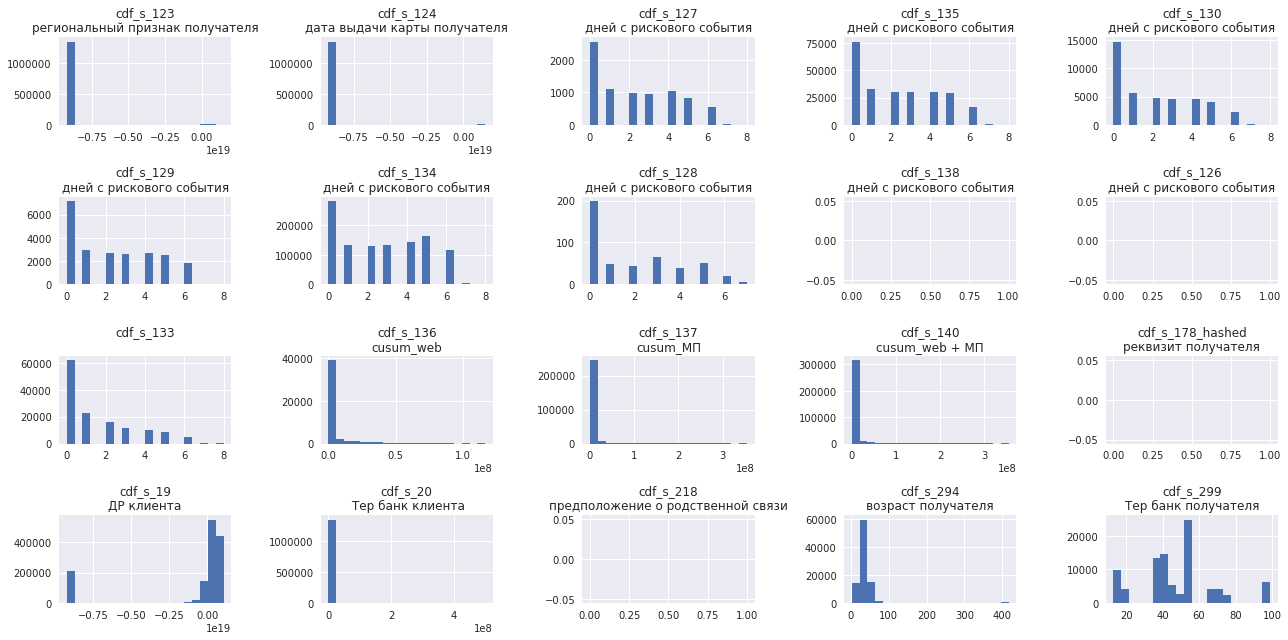

In [77]:
fig, axes = plt.subplots(4, 5, figsize=(18, 9))
#i = 0

for i, feature in enumerate(cdf_cols):
    #print(feature)
    #print(i // 5, i % 5)
    ax = axes[i // 5, i % 5]
    ax.hist(pd.to_numeric(chunk[feature], errors='coerce').dropna(), bins=20)
    #plt.figure()
    #plt.hist(pd.to_numeric(chunk[feature], errors='coerce').dropna(), bins=20)
    #plt.show()
    ax.set_title(feature + '\n' + feature_descr.get(feature, ''))
fig.tight_layout()

In [16]:
other_cols = set(chunk.columns.values) - set(cdf_cols) - {'custom_mark'}
len(other_cols)

23

/home/alex/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


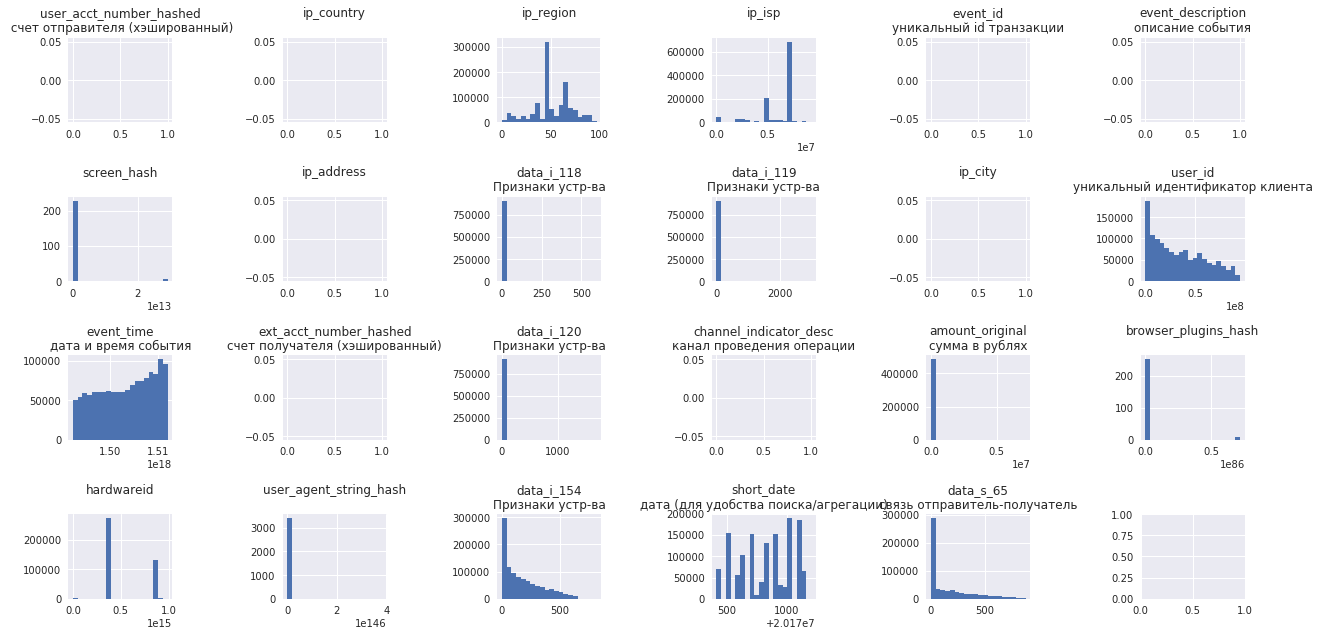

In [17]:
fig, axes = plt.subplots(4, 6, figsize=(18, 9))
#i = 0

for i, feature in enumerate(other_cols):
    ax = axes[i // 6, i % 6]
    ax.hist(pd.to_numeric(chunk[feature], errors='coerce').dropna(), bins=20)
    ax.set_title(feature + '\n' + feature_descr.get(feature, ''))
fig.tight_layout()

/home/alex/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


UnboundLocalError: local variable 'ax' referenced before assignment

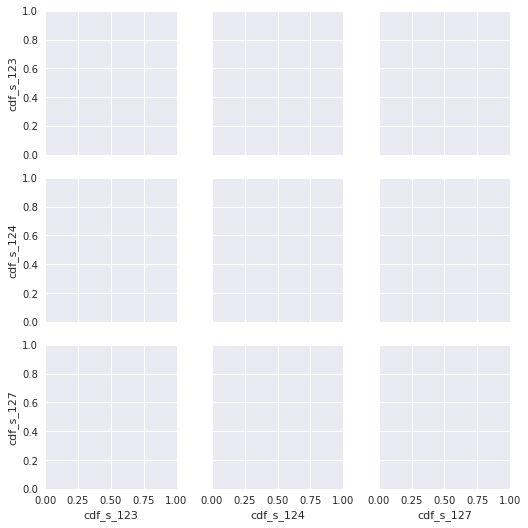

In [18]:
sns.pairplot(chunk, vars=cdf_cols[0:3],
    hue="custom_mark", diag_kind="kde", dropna=True)

/home/alex/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


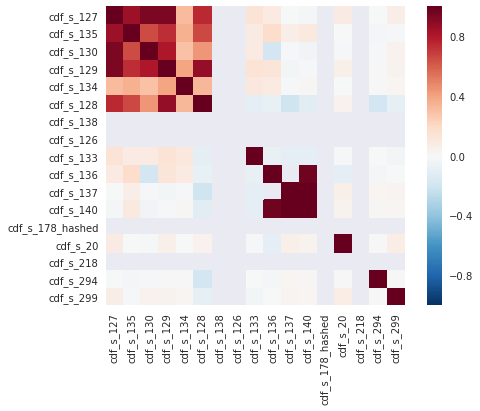

In [20]:
_ = sns.heatmap(chunk[cdf_cols].corr(), square=True)

/home/alex/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


ValueError: dictionary update sequence element #0 has length 31; 2 is required

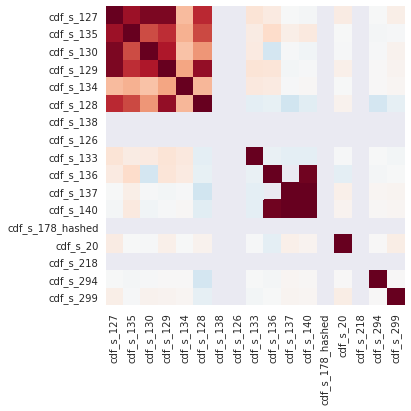

In [27]:
_ = sns.heatmap(chunk[cdf_cols].corr(), square=True, annot=True, annot_kws=[feature_descr.get(c, c) for c in cdf_cols])

/home/alex/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


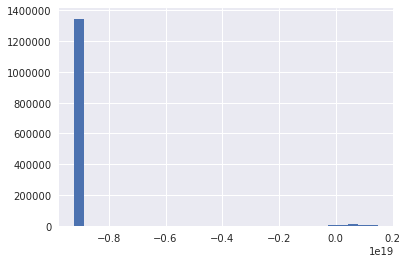

In [40]:
pd.to_numeric(chunk[feature], errors='coerce').dropna().hist(bins=30)

In [11]:
train_chunks, test_chunks = [], []

In [ ]:
for fname in tqdm_notebook(train_files[:FIRST_N]):
    chunk = pd.read_feather(fname)
    train_chunks.append(chunk[['user_id', 'short_date', 'custom_mark']].copy())

In [ ]:
for fname in tqdm_notebook(test_files[:FIRST_N]):
    chunk = pd.read_feather(fname)
    test_chunks.append(chunk[['user_id', 'short_date']].copy())

In [ ]:
chunk = pd.read_feather(train_files[0])

In [ ]:
chunk.columns

In [ ]:
chunk[['user_id', 'short_date']]

In [ ]:
chunk

In [ ]:
hashed_set = set()

In [ ]:
for fname in tqdm_notebook(train_files[:FIRST_N]):
    chunk = pd.read_feather(fname)
    hashed_set |= set(chunk['user_acct_number_hashed']) | set(chunk['ext_acct_number_hashed'])

In [ ]:
len(hashed_set)

In [ ]:
acc_dict = {}

In [ ]:
len(acc_dict)

In [ ]:
for h in hashed_set:
    acc_dict[h] = str(len(acc_dict)) + '@A'

In [ ]:
selected_cols = ['user_id', 'short_date', 'user_acct_number_hashed', 
                 'ext_acct_number_hashed', 'custom_mark', 'channel_indicator_desc', 'amount_original']

In [ ]:
chunks = []

In [ ]:
for fname in tqdm_notebook(train_files):
    chunk = pd.read_feather(fname)
    chunk = chunk[selected_cols].copy()
    chunk['is_fraud'] = chunk['custom_mark'].apply(cust_mark_to_class)
    chunk = chunk.loc[(chunk['user_acct_number_hashed'] != 'null') & (chunk['ext_acct_number_hashed'] != 'null')].copy()

    for usr, ext in zip(chunk['user_acct_number_hashed'], chunk['ext_acct_number_hashed']):
        if not (usr in acc_dict.keys()):
            acc_dict[usr] = str(len(acc_dict)) + '@A'
        if not (ext in acc_dict.keys()):
            acc_dict[ext] = str(len(acc_dict)) + '@A'

    chunk['user_acct_number_hashed'] = [acc_dict[x] for x in chunk['user_acct_number_hashed']]
    chunk['ext_acct_number_hashed'] = [acc_dict[x] for x in chunk['ext_acct_number_hashed']]
    chunks.append(chunk)

In [ ]:
chunks_df = pd.concat(chunks)#.shape

In [ ]:
del chunks

In [ ]:
gc.collect()

In [ ]:
chunks_df.shape

In [ ]:
chunks_df.rename(columns = {'user_acct_number_hashed': 'hacc_user', 'ext_acct_number_hashed': 'hacc_ext'}, inplace=True)

In [ ]:
chunks_df.head(5)

In [ ]:
chunks_df['channel_indicator_desc'].value_counts(dropna=False)

In [ ]:
chunks_df['is_fraud'].value_counts()

In [ ]:
chunks_df['hacc_user'].value_counts()

In [ ]:
chunks_df['hacc_ext'].value_counts()

In [ ]:
edges_set = set(zip(chunks_df['hacc_user'], chunks_df['hacc_ext']))

In [ ]:
len(edges_set)

In [ ]:
g = nx.Graph(directed=False)

In [ ]:
list(edges_set)[0]

In [ ]:
for v1, v2 in tqdm_notebook(edges_set):
    g.add_edge(v1, v2)

In [ ]:
%%time
nx.components.number_connected_components(g)

In [ ]:
%%time
components = [x for x in tqdm_notebook(nx.components.connected_components(g))]

In [ ]:
chunks_df.head(5)

In [ ]:
fraud_df = chunks_df.loc[chunks_df['is_fraud'] == 1]

In [ ]:
fraud_accs_full = set(fraud_df['hacc_user']) | set(fraud_df['hacc_ext'])

In [ ]:
components[1] & fraud_accs_full

In [ ]:
comp_ratio = pd.DataFrame([(len(x), len(x & fraud_accs_full)) for x in components], columns = ['size', 'n_fraud'])

In [ ]:
comp_ratio.groupby('size')['n_fraud'].agg(np.sum)

In [ ]:
g_dir = nx.Graph(directed=True)

In [ ]:
for v1, v2 in tqdm_notebook(edges_set):
    g_dir.add_edge(v1, v2)

In [ ]:
gc.collect()

In [ ]:
g_fraud = nx.Graph(directed=False)

In [ ]:
for v1, v2 in tqdm_notebook([x for x in edges_set if (x[0] in fraud_accs_full) or (x[1] in fraud_accs_full)]):
    g_fraud.add_edge(v1, v2)

In [ ]:
comm_fraud = [x for x in tqdm_notebook(nx.components.connected_components(g_fraud))]

In [ ]:
[(len(x), len(x & fraud_accs_full)) for x in comm_fraud]

In [ ]:
a =g_fraud.subgraph(comm_fraud)

In [ ]:
chunks_df[['']]

In [ ]:
chunk

In [ ]:
chunk.loc[(chunk['user_acct_number_hashed'] != 'null') & (chunk['ext_acct_number_hashed'] != 'null')]

In [ ]:
chunk['user_id'].value_counts()

In [ ]:
pd.read_feather()

In [ ]:
g.add_edge

---

# подвал ниже

## Работа с БД sqlite, создание дополнительных индексов

In [ ]:
%matplotlib inline

In [ ]:
!cd; cd -

In [ ]:
# создание коннекта к БД и крурсора для запросов
conn = sqlite3.connect('../data/input/hse_sqlite')
c = conn.cursor()

# создание engine для чтения данных в DataFrame
engine = sa.create_engine('sqlite:///../data/input/hse_sqlite.db')

In [ ]:
# пример получения перечня таблиц (в данном случае она будет 1)
c.execute("SELECT name FROM sqlite_master WHERE type='table';")
print ('Перечень таблиц: {0}\r\n\r\n'.format(c.fetchall()))

# перечень столбцов
c.execute("SELECT * FROM rsa_event_log LIMIT 1;")
cols = [descr[0] for descr in c.description]
print ('Столбцы в таблице: {0}'.format(cols))

### Подробнее что есть что

'event_id'- уникальный id транзакции

'short_date' - дата (для удобства поиска/агрегации)

'user_id' - уникальный идентификатор клиента

'event_time' - дата и время собятия

'custom_mark'- результат разбора события

'channel_indicator_desc' - канал проведения операции (web, мобильное приложение, SMS-банк и пр.)

'event_description' - описание непосредственно события (например, вход в систему или перевод, оплата услуг)

'amount_original' - сумма в рублях

'user_agent_string_hash', 'browser_plugins_hash', 'screen_hash' - различные признаки устройства (с определенной степенью точности позволяет понять уникальность устройства в разрезе пользователя)

ip_address', 'ip_country', 'ip_region', 'ip_city', 'ip_isp' - данные, связанные с IP (регион, город и интернет-провадйер по БД гео-IP)
'hardwareid' - уникальный идентификатор устройства для канала мобильных приложений

'user_acct_number_hashed'- счет отправителя (хэшированный)
'ext_acct_number_hashed'- счет получателя (хэшированный)


'data_s_65' - результат определения связи между отправителем и получателем (чем больше, тем сильнее связь) 
'data_i_118', 'data_i_119’, 'data_i_120', 'data_i_154' - ряд признаков, которые описывают устройство, с которого проводятся операции
 


 'cdf_s_136','cdf_s_137','cdf_s_140'- кумулятивные суммы операций за сутки в web, МП, web + МП
 'cdf_s_218'- предполагаемое наличие родственной связи 
 'cdf_s_127', 'cdf_s_135', 'cdf_s_130', 'cdf_s_129', 'cdf_s_134', 'cdf_s_128', 'cdf_s_138', 'cdf_s_126' - дней с момента различных рисковых событий



 'cdf_s_19'- ДР клиента
 'cdf_s_20'- Территориальный банк клиента (региональный признак)
 'cdf_s_299'- Тер банк получателя (региональный признак)

 'cdf_s_294'- возраст получателя

 'cdf_s_123'- региональный признак получателя (более локальный по сравнению с ТБ)
 'cdf_s_124'- дата выдачи карты получателя

 'cdf_s_178_hashed' - реквизит получателя

In [ ]:
# функция получения lable из csutom_mark

def cust_mark_to_class(custom_mark):
    """
    Преобразует входящее значение CUSTOM_MARK в класс
    return:
        1 - фрод
        0 - легитимная
        -1 - неизвестно
    """
    ret = -1
    if custom_mark in ['F','S']:
        ret = 1
    elif custom_mark in ['A','G', np.NaN]:
        ret = 0
    
    return ret

In [ ]:
# Пример форомирования DataFrame из БД с заполнением типа полей

def transform_cols (df, dict_col_types = None):
    # Расширяйте для необходимых столбцов и их явной типизации
    if dict_col_types is None:
        dict_col_types = {
        'amount_original':(float, 0.0),
        'cdf_s_126':(str, u'null'),
        'cdf_s_138':(str, u'null'),
        'channel_indicator':(str, u'null'),
        'event_description':(str, u'null'),
        'cdf_s_294':(int, 0),
        'cdf_s_140':(float, 0.0),
        'data_i_120':(int, 0),
        'cdf_s_218':(str, u'null'),
        'data_s_65':(int, 0),
        'cdf_s_127':(int, 30),
        'cdf_s_135':(int, 30),
        'cdf_s_130':(int, 30),
        'cdf_s_129':(int, 30),
        'cdf_s_134':(int, 30),
        'data_i_154':(float, np.nan),
        'cdf_s_133':(int, 30),
        'cdf_s_20':(str, u'null'),
        'cdf_s_299':(str, u'null'),
        }
                
    if df.shape[0] > 0:
        df.replace(u'null', np.nan, inplace=True)

        for i in dict_col_types:
            if i in df.columns:
                df[i] = df[i].fillna(dict_col_types[i][1]).astype(dict_col_types[i][0])
    
    return df
    

def df_from_sql (sql, parse_dates = ['event_time','cdf_s_19', 'cdf_s_123','cdf_s_124'], dict_col_types = None, chunk_size = None, engine=engine):
    """
    Функция вощвращающая df в результате переданного sql-запроса
    Также поддерживается приведение столбцов к заданным типам 
    и чтение по блокам
    """
     
    if chunk_size is not None:
        df_iter =  [transform_cols(chunk, dict_col_types) for chunk in pd.read_sql_query(sql, engine, parse_dates = parse_dates, chunksize=chunk_size)]
    else:
        df_iter = transform_cols(pd.read_sql_query(sql, engine, parse_dates = parse_dates), dict_col_types)
        #df_iter = pd.read_sql_query(sql, engine, con=conn,  parse_dates = parse_dates)
    
    return df_iter


Я тут по факту продублировал индексы.

In [ ]:
# создание индексов для ускорения поиска
# описанные здесь уже созданы в предоставленной БД, при необходимотси можете расширить набор
cols_to_index = ['user_id', 'custom_mark', 'short_date',  'channel_indicator_desc', 'event_description']

for col in cols_to_index:
    c.execute('CREATE INDEX {ix} on {tn}({cn})'\
            .format(ix='indx_new_{0}'.format(col), tn='rsa_event_log', cn=col)) # add new index indx_new_{0}

c.execute('CREATE INDEX date_user_event on rsa_event_log(short_date, user_id, event_description);')   
    
conn.commit()

In [ ]:
#  Общий срез по данным
c.execute("select COUNT(*) from rsa_event_log;")
print ('Общее число транзакций: {0}'.format(c.fetchall()))


# Число уникальных пользователей
c.execute("select COUNT(DISTINCT user_id) from rsa_event_log;")
print ("Уникальных пользователей: {0}".format(c.fetchall()))

# Временной диапазон и количество клиентов
c.execute("select min(short_date), max(short_date) from rsa_event_log;")
print('Диапазон дат: {0}'.format(c.fetchall()))


In [ ]:
start_date = "20171029"
end_date = "20171128"

In [ ]:
sql = """select AVG(short_date) from rsa_event_log 
                        where short_date between {start} and {end};""".format(start=start_date, end=end_date)

In [ ]:
c.execute(sql)
print ('Общее число транзакций: {0}'.format(c.fetchall()))

In [ ]:
sql

###  Summary анализ данных (на примере 5% выборки пользователей)
1) Общее число записей и столбцов

2) Типы данных, numeric, categorical, распределения, число уникальных типов

3) Вариативность и NULL

In [ ]:
all_users = df_from_sql('select DISTINCT user_id from rsa_event_log;',
                        engine=conn,
                        parse_dates=None)

In [ ]:
sample_users = all_users.sample(frac=0.05).user_id.astype(str).tolist()

In [ ]:
# достаточно долгий запрос
data = df_from_sql("select * from rsa_event_log where user_id in ({0});".format(str(sample_users)[1:-1]), engine=conn)

In [ ]:
#data.to_csv('../data/data1per.csv')

In [ ]:
!ls ../

In [ ]:
data = pd.read_csv('../data/data1per.csv', index_col=0)

In [ ]:
print ('Shape: {0}'.format(data.shape))
data.head(10)

In [ ]:
#Сводная статистика по датасету


def summary_stats(data):
    df_summary_stats = pd.DataFrame(index=data.columns,columns=['type','nunique', 'top_3_values_freq', 'null_rate', 'std','min', 'max', 'mean', 'quantile'])
    for col in data.columns:

        col_type = data[col].dtype
        if col_type in ['object','str']:
            df_summary_stats.loc[col][[
                'type',
                'nunique', 
                'top_3_values_freq', 
                'null_rate'
            ]] = \
            col_type, \
            data[col].nunique(),\
            dict(data[col].value_counts().head(3)*100.0/data.shape[0]),\
            sum(data[col].isnull())*100.0/data.shape[0]

        if col_type in ['int64', 'float64', 'int32', 'float32']:
            df_summary_stats.loc[col][[
                'type',
                'null_rate',
                'std',
                'min',
                'max',
                'mean',
                'quantile'
            ]] = \
            col_type, \
            sum(data[col].isnull())*100.0/data.shape[0],\
            data[col].std(),\
            data[col].min(),\
            data[col].max(),\
            data[col].mean(),\
            dict(data[col].quantile([0.25,0.5,0.75]))

        if col_type == 'datetime64[ns]':
            df_summary_stats.loc[col][[
                'type',
                'null_rate',
                'min',
                'max',
            ]] = \
            col_type, \
            sum(data[col].isnull())*100.0/data.shape[0],\
            data[col].min(),\
            data[col].max()
        
    return df_summary_stats

In [ ]:
# Обратите внимание, что у многих столбцов тип определился как object (исключая заданные нами) - обычно такое бывает когда столбец содержит Nan или же не был определен тип данных (например, для строк)
summary_stats(data)

In [ ]:
#Типы операций
data.event_description.value_counts(dropna=False)

### Постановка задачи - разработка модели, осуществляющей выявление мошенничество в каналах WEBAPI, MOBILEAPI, ATMAPI

In [ ]:
# И тут мы видим лучшую заполненнсоть полей
transaction_data = data[data.event_description.isin([u'Перевод частному лицу',u'Оплата услуг',u'Перевод между своими счетами и картами'])]
print(transaction_data.shape)
summary_stats(transaction_data)

In [ ]:
data = transaction_data = None

## Feature engineering

### Поскольку объем данных достаточно существенный и одновременно в память его не прогрузить, то необходимо рассчитывать фичи по "порциями". Cплитить будем по пользователям

In [ ]:
# сначала определим временной диапазон, в котором будем тренировать и валидировать модель исходя из распределения фрода
fraud_df = df_from_sql("select * from rsa_event_log where custom_mark in ('F','S')", engine=conn)

# основная доля сосредоточена в период с 29.10 по 28.11, его и выбираем
fraud_df.groupby('short_date').event_id.count()

In [ ]:
plt.plot(fraud_df.groupby('short_date').event_id.count())
plt.show()

## Обратите внимание на выбор диапазона 

In [ ]:
start_date = "20171029"
end_date = "20171128"

In [ ]:
# для ускорения проверки корректности расчета фич - используйте sample из 1-2% пользователей
all_users = df_from_sql("select distinct user_id from rsa_event_log", engine=conn,parse_dates=None)
users_sample = all_users.sample(frac=0.01).user_id.astype(str).tolist()

In [ ]:
# Функция рассчет по пачкам, если dataset не помещается в память

def features_chunk_handler(sql, calc_feat, chunk_size=5000):
    """
    sql - запрос выбирающий данные и возвращающий df необходимого для calc_feat метода
    calc_feat - процедура, осуществляющая расчет фичей на основании входного DF
    """
    rez_df = pd.DataFrame()
    for chunk in tqdm_notebook(df_from_sql(sql, engine=conn, chunk_size=chunk_size), total = 72000000 // chunk_size):
        
        # При необходимости - добавить еще запись в БД sqlite рассчитанных признаков
        feat_chunk = calc_feat(chunk)
        #feat_chunk = chunk
        
        rez_df = pd.concat([rez_df, feat_chunk], ignore_index=True)
        
    return rez_df
        

In [ ]:
from tqdm import tqdm_notebook

In [ ]:
def map_field(data, field_name, target_name, alpha):
    global_mean = data[target_name].mean()
    counters = data.groupby(field_name)[target_name].mean()
    n_counters = data.groupby(field_name)[target_name].count()
    out = ((data[field_name].map(counters) + global_mean * alpha)/ \
           (data[field_name].map(n_counters) + alpha))
    return out

In [ ]:
def calc_base_features (data):
    feat_matrix = pd.DataFrame()
    # sampling - data = data[data.user_id.isin(users_sample) & data.event_description.isin([u'Перевод частному лицу',u'Оплата услуг',u'Перевод между своими счетами и картами'])]
    data = data[data.event_description.isin([u'Перевод частному лицу',u'Оплата услуг',u'Перевод между своими счетами и картами'])]
    
    if data.shape[0] == 0:
        return feat_matrix
    
    # заполняем ряд пропусков
    data.cdf_s_140 = data.cdf_s_140.fillna(0).astype(float)/1000 # кумулятивная сумма опреаций за сутки, если не заполнена, то значит это первая операций, т.е. = 0
    data.data_i_120.fillna(1, inplace=True)

    
    feat_matrix['event_id'] = data.event_id
    feat_matrix['user_id'] = data.user_id

    feat_matrix['custom_mark'] = data.custom_mark    
    feat_matrix['event_time'] = data.event_time

    feat_matrix['amount'] = data.amount_original
    
    feat_matrix['client_age'] = (data.event_time - data.cdf_s_19).apply(lambda x: x.days/360)
 
        
    feat_matrix['cat_new_ip'] = data.cdf_s_126.apply(lambda x: 1 if x == u'ДА' else 0 if x == u'НЕТ' else 2)
    feat_matrix['cat_new_prov'] = data.cdf_s_138.apply(lambda x: 1 if x == u'ДА' else 0 if x == u'НЕТ' else 2)
    feat_matrix['channel_op'] = data.channel_indicator.apply(lambda x: 0 if x == u'MOBILE' else 1 if x == u'WEB' else 2)
    feat_matrix['op_type'] = data.event_description.apply(lambda x:
            0 if x == u'Перевод частному лицу' else 1 if x==u'Оплата услуг' else 2 if x ==u'Перевод между своими счетами и картами' else 3)


    feat_matrix ['recip_age'] = data.cdf_s_294.apply(lambda x: 1 if x == 0 else 0) # бинарный флаг определяющий наличие возраста получателя (полезен для линейных моделей, менее для деревьев с учетом следующего признака)
    
    
    feat_matrix['age_diff'] = feat_matrix.client_age - data.cdf_s_294.apply(lambda x: int(x) if x != 0 else 1000) # разница возорастов получателей и отправителей, если отсутствует/неприменимо, то padding 500    
  
    
    feat_matrix['cumulative_sum_total'] = data.cdf_s_140 # кумулятивная сумма операций за сутки в каналах web и МП
    
    feat_matrix['data_i_120'] = data.data_i_120 
    
    
    feat_matrix['relative'] = data.cdf_s_218.apply(lambda x: 1 if x == u'ДА' else 0) # перевод родственнику
    
    feat_matrix['know_recip_power'] = data.data_s_65.apply(lambda x: x if x is not None else 0) # сила связи отправителя и получателя
    
    
    feat_matrix['cdf_s_127'] = data.cdf_s_127#.apply(lambda x: 1 if x is not None else 0)
    feat_matrix['cdf_s_135'] = data.cdf_s_135#.apply(lambda x: 1 if x is not None else 0)
    feat_matrix['cdf_s_130'] = data.cdf_s_130#.apply(lambda x: 1 if x is not None else 0)
    feat_matrix['cdf_s_129'] = data.cdf_s_129#.apply(lambda x: 1 if x is not None else 0)
    feat_matrix['cdf_s_134'] = data.cdf_s_134#.apply(lambda x: 1 if x is not None else 0)
    feat_matrix['data_i_154'] = data.data_i_154.apply(lambda x: x if x is not None else -150)
    feat_matrix['cdf_s_133'] = data.cdf_s_133#.apply(lambda x: 1 if x is not None else 0)
    feat_matrix['data_i_120'] = data.data_i_120
    feat_matrix['know_recip_card_age'] = data.cdf_s_124.apply(lambda x: 1 if x is not None else 0)
    
    
    
    feat_matrix['recip_card_age'] = (data.event_time - data.cdf_s_124).apply(lambda x: x.days if type(x) is not pd.tslib.NaTType else 2000)
    
    feat_matrix['cat_client_region'] = data.cdf_s_20.astype(str)
    feat_matrix['one_region'] = (data.cdf_s_20 == data.cdf_s_299).astype(int) # сравнение регионов
    
    feat_matrix["amntTo136"] = (data["amount_original"].fillna(0) / \
        (data["amount_original"].fillna(0) + data["cdf_s_136"].fillna(0) + 1))
    feat_matrix["amtnTo137"] = (data["amount_original"].fillna(0) / \
        (data["amount_original"].fillna(0) + data["cdf_s_137"].fillna(0) + 1))
    feat_matrix["amtnTo140"] = (data["amount_original"].fillna(0) / \
        (data["amount_original"].fillna(0) + data["cdf_s_140"].fillna(0) + 1))

    feat_matrix["channel_indicator_desc"] = map_field(data, "channel_indicator_desc", "custom_mark", alpha=10000)
    feat_matrix["cdf_s_138"] = map_field(data, "cdf_s_138", "custom_mark", alpha=10000)
    feat_matrix["cdf_s_126"] = map_field(data, "cdf_s_126", "custom_mark", alpha=10000)
    feat_matrix["cdf_s_218"] = map_field(data, "cdf_s_218", "custom_mark", alpha=10000)
    feat_matrix["event_description"] = map_field(data, "event_description", "custom_mark", alpha=10000)
    
    #ADD NEW FEATURES
        
    return feat_matrix

# Задание - реализовать как минимум 7 новых признаков, 3 из которых должны быть обработкой категориальных столбцов

Пример:

Кортежи регионов отправителя и получателя

ISP провайдера

Подсети класса B

### Расчет фичей

In [ ]:
sql = """select * from rsa_event_log 
                        where short_date between {start} and {end};""".format(start=start_date, end=end_date)

In [ ]:
st = datetime.datetime.now()
trans_feat = features_chunk_handler(sql, calc_base_features, 100000)
end = datetime.datetime.now()
print(end - st)

In [ ]:
trans_feat.to_csv('./data/feat_matrix_prt1.csv', sep=';', index=False)

In [ ]:
trans_feat = pd.read_csv('./data/feat_matrix_prt1.csv',sep=';', parse_dates=['event_time'])

In [ ]:
trans_feat.shape

In [ ]:
trans_feat.custom_mark.value_counts(dropna=False)

In [ ]:
trans_feat.custom_mark.value_counts(dropna=False)

### Вспомогательные функции для работы с временнЫми данными

In [ ]:
# будем считать данные на ежедневном базисе по квантилям клиента
trans_data = df_from_sql("select * from rsa_event_log where user_id in ({0})".format(str(users_sample)[1:-1]))

In [ ]:
# как уже говорились при работе с данными, имеющими временной аспект крайне важно отсекать транзакции, 
# идущие после оцениваемого события

# кроме того зачастую бывает полезно создавать фичи не за весь доступный горизонт данных, 
# а за различные временные окна
def timeframe_trans(trans, date_threshold=None, depth=None):
    """
    Функция отбирающая тразакции в заданном временном окне
    :param trans: весь массив транзакций
    :param date_threshold: дата и время отсечки, если не указан, то datetime.now()
    :param depth: глубина периода от даты отсечки, если не указан, то от текущего момента
    :return:
    
    """
    if date_threshold and depth:
        interested_trans = trans[trans.event_time.between(date_threshold - depth, date_threshold)]
    elif date_threshold and depth is None:
        interested_trans = trans[trans.event_time <= date_threshold]
    elif date_threshold is None and depth:
        interested_trans = trans[trans.event_time.between(datetime.datetime.now() - depth, datetime.datetime.now())]
    else:
        interested_trans = trans

    return interested_trans


def calc_quants_per_user (trans, col_name='amount_original', quants=np.arange(0.1, 1.1, .1), feat_name='amount_q_', depth=None, start_date = datetime.date(2017,10,29), 
                 end_date = datetime.date(2017,11,29)):
    """
    Функция рассчитывающая квантили для пользователя с округлением до дня
    """
    
    time_delta = end_date - start_date
    #можно переопределить и выбрать другой временной интервал
    list_of_days = [start_date + datetime.timedelta(days=i) for i in range(time_delta.days + 1)]
    
    rez_df = pd.DataFrame()
    
    for day in list_of_days:
        if depth is None:
            cur_cutoff = trans[trans.event_time < day]
        else:
            cur_cutoff = trans[(trans.event_time < day)&(trans.event_time > (day - depth))]
            
        if cur_cutoff.shape[0] >= 1:
            res = cur_cutoff[col_name].quantile(quants)
        else:
            res = [0 for i in quants]
    
        for i in zip(quants, res):
            rez_df.loc[day, feat_name + str(i[0])] = i[1]
    
        
    
    return rez_df


def all_usr_quants(users_list, number_of_splits = 900, col_name = 'amount_original', quants=np.arange(0.1, 1.1, .1), feat_name='amount_q_', depth=None, start_date = datetime.date(2017,10,29), 
                 end_date = datetime.date(2017,11,29)):
    """
    Расчет квантилей по всем пользователям со сплитованием на подмножества
    """
    rez_df = pd.DataFrame()
    usr_chunks = np.array_split(users_list, number_of_splits)
    
    for chunk in usr_chunks:
        
        trans_data = df_from_sql("select user_id, event_time, {col} from rsa_event_log where user_id in ({users})".format(col = col_name, users=str(list(chunk))[1:-1]), parse_dates=['event_time'])
        chunk_df =  trans_data.groupby('user_id').apply(lambda x: 
                        # В даннос случае x - dataframe с транзакциями 1ого пользователя
                        calc_quants_per_user(x[x[col_name] <> 0], col_name=col_name, feat_name=feat_name, quants=quants, depth = depth, start_date=start_date, end_date=end_date)
                    )
        rez_df = pd.concat([rez_df, chunk_df])
        
    return rez_df

In [ ]:
# Пример как получить транзакции пользователей за 2 недели до их последней транзакции
trans_data[trans_data.user_id.isin(users_sample)].groupby('user_id').apply(lambda x: timeframe_trans(x, x.event_time.max(), depth=datetime.timedelta(days=14))).head(25)

In [ ]:
victims = trans_feat[trans_feat.custom_mark.isin(['F','S'])].user_id.sample(frac=1).astype(str).unique().tolist()
print len(victims)

In [ ]:
# Добавляем квантили по операциям клиента за 30 дней до транзакции и 90 дней

# 30 дней
df_30_days = all_usr_quants(all_users.user_id.astype(str).unique().tolist(), number_of_splits=20, col_name="amount_original", depth=datetime.timedelta(days=30), feat_name='amnt_30_q_')

# 90 дней
df_90_days = all_usr_quants(all_users.user_id.astype(str).unique().tolist(), 20, col_name="amount_original", depth=datetime.timedelta(days=90), feat_name='amnt_90_q_')

In [ ]:
quant_features = pd.merge(df_30_days, df_90_days, left_index=True, right_index=True)
quant_features.reset_index(inplace=True)
quant_features.rename(index=str, columns={'level_1':'short_date'}, inplace=True)

In [ ]:
quant_features.head()

In [ ]:
quant_features.to_csv('quant_features.csv')

### Добавляем в матрицу фичей квантили и рассчитываем доп признаки по базовым фичам, которые должны охарактеризовать текущее поведение клиента относительно его предыдущих трат

In [ ]:
trans_feat['short_date'] = trans_feat.event_time.apply(lambda x: x.date())

In [ ]:
rez_matrix = trans_feat.merge(quant_features, on=['user_id','short_date'], how = 'inner')
rez_matrix.shape

In [ ]:
# добавляем отношение кумулятивной суммы операций за сутки к квантилям операций клиента (0.3, 0.5, 1.0)
for col in [i for i in rez_matrix.columns if any(col in i for col in ['_q_0.3','_q_0.5','_q_1.0'])]:
    rez_matrix['cumulative_sum_to_{0}'.format(col)] = rez_matrix.cumulative_sum_total/rez_matrix[col]

# добавляем отнощение суммы операции к максимальным квантилям
for col in [i for i in rez_matrix.columns if any(col in i for col in ['_q_1.0'])]:
    rez_matrix['amount_to_{0}'.format(col)] = rez_matrix.amount/rez_matrix[col]

In [ ]:
#заменяем деления inf от делений на 0
rez_matrix.replace(np.inf, 0, inplace=True)

rez_matrix['lable'] = rez_matrix.custom_mark.apply(lambda x: cust_mark_to_class(x))

In [ ]:
# удаляем неизвестные кейсы
rez_matrix = rez_matrix[rez_matrix.lable <> -1]

In [ ]:
print rez_matrix.shape
rez_matrix.head()

In [ ]:
#rez_matrix = pd.to_csv('rez_matrix_full.csv', sep=';')
#rez_matrix = pd.read_csv('rez_matrix_full.csv', sep=';', parse_dates=['event_time'])

## Задание - расширить квантили, добавив подразбиение по каналам проведения операций

In [ ]:
???

In [ ]:
rez_matrix.lable.value_counts()

In [ ]:
rez_matrix.groupby('lable').event_time.agg(['min', 'max'])

In [ ]:
rez_matrix[rez_matrix.lable == 1].event_time.quantile([0.25, 0.5,0.75,0.9])

## Подготовка split по времени

In [ ]:
# подготовим разбиение выборки - будем идти посуточно rolling window
rez_matrix['TS_indexer'] = rez_matrix.short_date
# оставляем уникальные индексы, по которым и будем строить разбиение через time series
unique_TS_split = np.array(sorted(rez_matrix.TS_indexer.unique()))

In [ ]:
print len(unique_TS_split)

## Задание - доработать indexer таким образом, чтобы он работал в парадигме  "забывающей" модели из презентации (меньший период легитимных, но фрод сохранять весь) ИЛИ ансамбль моделей

In [ ]:
???

## Выбираем максимальный предущий период времени, на котором будем тренироваться и число сплитов

In [ ]:
tscv = TimeSeriesSplit(n_splits=16, max_train_size=21)
for train_index, test_index in tscv.split(unique_TS_split):
    print("TRAIN LEN:", len(unique_TS_split[train_index]), "TEST LEN:", len(unique_TS_split[test_index]))

In [ ]:
# а так мы будем получать непосредственно транзакции в данном фолде    
rez_matrix[rez_matrix.TS_indexer.isin(unique_TS_split[test_index])]

In [ ]:
# мы выбрали, что доступный временно горизонт для модели должен составлять минимум 21 день, 
# поэтому нам нужно исключить начальные фолды, в которых данное условие не выполняется
# также для использования GridSearchCV нам потребуется вернуться непосредственно к индексам rez_matrix

#ВАЖНО! для корректной процедуры требуется сбросить индекс
rez_matrix.reset_index(drop=True, inplace=True)

temp_TS_cv = [
    (rez_matrix[rez_matrix.TS_indexer.isin(unique_TS_split[train_index])].index.tolist(), 
     rez_matrix[rez_matrix.TS_indexer.isin(unique_TS_split[test_index])].index.tolist()) for (train_index, test_index) in tscv.split(unique_TS_split) if len(train_index)>=21]

#еще необходимо исключить фолды, в которые не поало ни одного фрода
completed_TS_cv = [(train, test) for (train, test) in temp_TS_cv if rez_matrix.iloc[test].lable.sum() >= 1]

In [ ]:
print len(temp_TS_cv)
print len(completed_TS_cv)

In [ ]:
for i in range(len(completed_TS_cv)):
    print "Train period: " + str(rez_matrix.loc[completed_TS_cv[i][0]].event_time.min())+' - '+str(rez_matrix.loc[completed_TS_cv[i][0]].event_time.max())
    print "Test period: " + str(rez_matrix.loc[completed_TS_cv[i][1]].event_time.min())+' - '+str(rez_matrix.loc[completed_TS_cv[i][1]].event_time.max())
    print "\r\n"

In [ ]:
rez_matrix.columns

In [ ]:
X = rez_matrix.drop(['event_id', 'user_id','event_time', 'custom_mark', 'short_date','TS_indexer', 'lable'], axis=1).as_matrix()
y = rez_matrix.lable.as_matrix()

In [ ]:
len(completed_TS_cv)

In [ ]:
train_folds = completed_TS_cv[:6]
val_folds = completed_TS_cv[6:]

# Задание применить один из методов работы с несбалансированными классами, отличный от class_weight

In [ ]:
print('XGBoost with grid search')
# 
params={
    'max_depth': [3, 5, 8], 
    'subsample': [0.4, 0.6], 
    'colsample_bytree': [0.5, 0.7], 
    'n_estimators': [150, 250],
    'reg_alpha': [0.01, 0.03] 
}

xgb_clf = xgb.XGBClassifier(missing=np.NAN)
rs = GridSearchCV(xgb_clf,
                  params,
                  cv=train_folds,
                  scoring="neg_log_loss",
                  n_jobs=4,
                  verbose=2)
rs.fit(X, y)
best_est = rs.best_estimator_
print(best_est)

In [ ]:
predictor = xgb.XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.5,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=150, nthread=-1,
       objective='binary:logistic', reg_alpha=0.03, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.6)

In [ ]:
feats_names = rez_matrix.drop(['event_id', 'user_id','event_time', 'custom_mark', 'short_date','TS_indexer', 'lable'], axis=1).columns

In [ ]:
rez_matrix.cat_client_region = rez_matrix.cat_client_region.astype(int)

In [ ]:
f, axes = plt.subplots(1, 1, figsize=(10, 5))



y_real = []
y_proba = []
for i, (train_index, test_index) in enumerate(val_folds):
    print i
    #Xtrain, Xtest = X[train_index], X[test_index]
    Xtrain, Xtest = rez_matrix[feats_names].reset_index(drop=True).loc[train_index], rez_matrix[feats_names].reset_index(drop=True).loc[test_index]
    ytrain, ytest = y[train_index], y[test_index]
    predictor.fit(Xtrain, ytrain)
    pred_proba = predictor.predict_proba(Xtest)
    precision, recall, _ = precision_recall_curve(ytest, pred_proba[:,1])
    lab = 'Fold %d AUC=%.4f' % (i+1, auc(recall, precision))
    axes.step(recall, precision, label=lab)
    y_real.append(ytest)
    y_proba.append(pred_proba[:,1])

y_real = np.concatenate(y_real)
y_proba = np.concatenate(y_proba)
precision, recall, _ = precision_recall_curve(y_real, y_proba)
lab = 'Overall AUC=%.4f' % (auc(recall, precision))
axes.step(recall, precision, label=lab, lw=2, color='black')
axes.set_xlabel('Recall')
axes.set_ylabel('Precision')
axes.legend(loc='lower left', fontsize='small')

f.tight_layout()
plt.show()
f.savefig('result.png')

# А как нам из PR получить информацию по числу сработок? Откуда взять порого для FP? 

In [ ]:
???

## Примеры использования featrue importance, PDP, ICE

In [ ]:
feats_names = rez_matrix.drop(['event_id', 'user_id','event_time', 'custom_mark', 'short_date','TS_indexer', 'lable'], axis=1).columns

def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1

    outfile.close()

create_feature_map(feats_names)
    
importance = predictor.booster().get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

feat_df = pd.DataFrame(importance, columns=['feature', 'fscore'])

plt.figure()
feat_df.plot()
feat_df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(10, 25))
plt.gcf().savefig('features_importance.png')

## ICE experiments

In [ ]:
from pdpbox import pdp

In [ ]:
pdp.target_plot(rez_matrix, 'age_diff', 'age_diff', 'lable')

In [ ]:
pdp_age_diff = pdp.pdp_isolate(predictor, rez_matrix[feats_names].reset_index(), 'age_diff')

In [ ]:
pdp.pdp_plot(pdp_age_diff, 'age_diff', plot_org_pts=True, plot_lines=True, frac_to_plot=10000)

In [ ]:
pdp.pdp_plot(pdp_age_diff, 'age_diff', plot_org_pts=True, plot_lines=True, frac_to_plot=3500, cluster=True, n_cluster_centers=15, center=True)

In [ ]:
age_sum = pdp.pdp_interact(predictor, rez_matrix[rez_matrix.lable == 1][feats_names].reset_index(drop=True), ['client_age','amount'], num_grid_points=[10, 10])

In [ ]:
age_sum.pdp_isolate_out1.ice_lines.actual_preds.max()

In [ ]:
age_sum.pdp_isolate_out1.ice_lines.actual_preds.describe()

In [ ]:
pdp.pdp_interact_plot(age_sum, ['client_age', 'amount'], center=True, plot_org_pts=True, plot_lines=True, frac_to_plot=5000, x_quantile=True)

In [ ]:
pdp.pdp_interact_plot(inter_age, ['client_age', 'age_diff'], center=True, plot_org_pts=True, plot_lines=True, frac_to_plot=10000, x_quantile=True)

# Задание - взять и посмотреть какие главниые фичи выделит SHAP-подход, сравнить взаимное влияние аналогичных признаков, прокомеенитровать 2 конкретных предсказания трназакции